In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 7.5 MB/s 
     |████████████████████████████████| 197 kB 37.9 MB/s 
     |████████████████████████████████| 1.2 MB 18.1 MB/s 
     |████████████████████████████████| 60 kB 2.8 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fbd251bb61994a46aa3f7b25f2f4f34d')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [28]:
results = search_images_bing(key, 'siamese cat')
ims = results.attrgot('contentUrl')
len(ims)

150

In [29]:
cat_types = 'oriental','siamese','ragdoll'
path = Path('cats')

In [30]:
if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [31]:
fns = get_image_files(path)
fns

(#424) [Path('cats/oriental/00000117.jpg'),Path('cats/oriental/00000079.jpeg'),Path('cats/oriental/00000073.jpg'),Path('cats/oriental/00000057.jpg'),Path('cats/oriental/00000130.jpg'),Path('cats/oriental/00000025.jpg'),Path('cats/oriental/00000045.jpg'),Path('cats/oriental/00000024.jpg'),Path('cats/oriental/00000037.jpg'),Path('cats/oriental/00000048.jpg')...]

In [32]:
failed = verify_images(fns)
failed

(#0) []

In [33]:
failed.map(Path.unlink);

In [34]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [35]:
dls = cats.dataloaders(path)

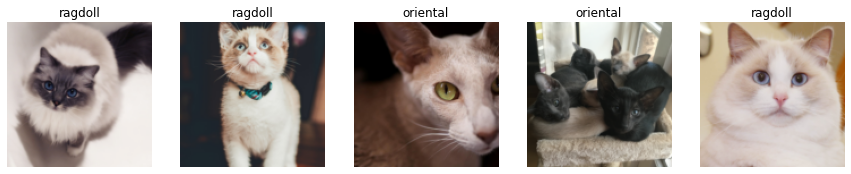

In [36]:
dls.valid.show_batch(max_n=5, nrows=1)

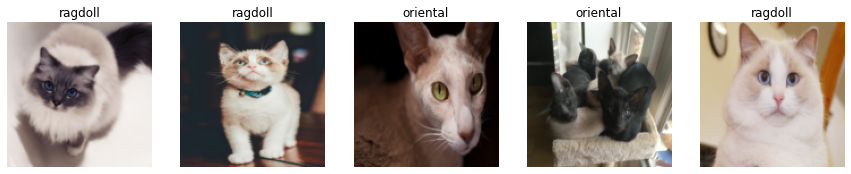

In [37]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

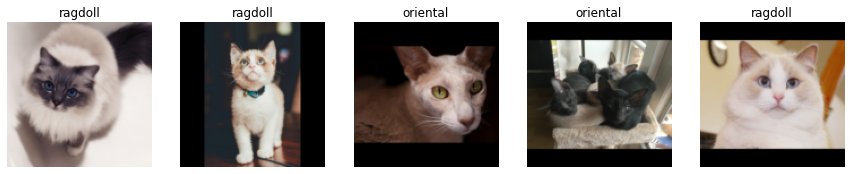

In [38]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

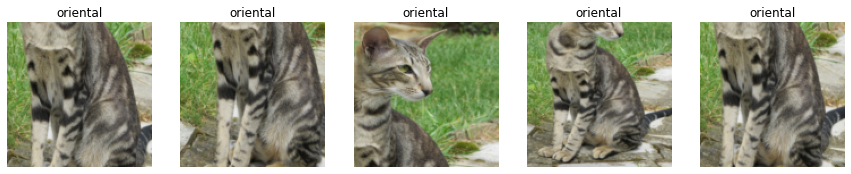

In [39]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

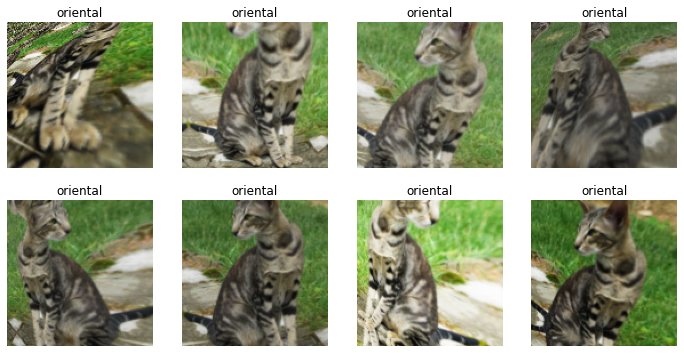

In [40]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [41]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [42]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.551282,0.631005,0.226190,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.500088,0.423461,0.119048,01:53
1,0.432053,0.454297,0.107143,02:00
2,0.344785,0.461845,0.095238,01:55
3,0.286621,0.468010,0.083333,01:54


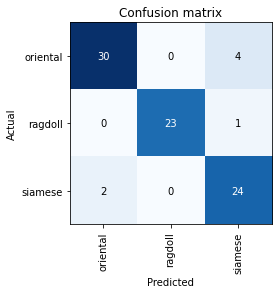

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

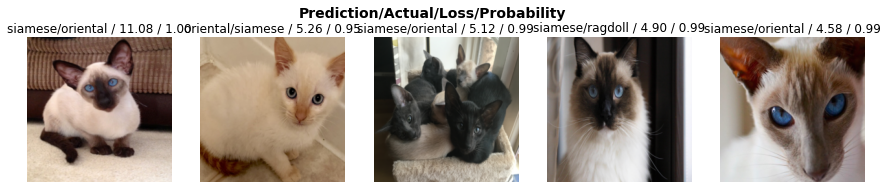

In [44]:
interp.plot_top_losses(5, nrows=1)

In [47]:
dest = 'images/siamese.jpg'
download_url(ims[0], dest)
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/siamese.jpg')
learn_inf.dls.vocab

['oriental', 'ragdoll', 'siamese']

In [49]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/siamese.jpg'])
img = PILImage.create(btn_upload.data[-1])
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
pred,pred_idx,probs = learn_inf.predict(img)



In [50]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
btn_run = widgets.Button(description='Classify')
btn_run
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [51]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()


In [52]:
#hide_output
VBox([widgets.Label('Select your cat!'), 
      btn_upload, btn_run, out_pl, lbl_pred])